# Project 3 - Completly Fair Schuedler Analysis
### CS337 Operating Systems Prof. Al Madi - Spring 2022
###### Matthew Bass : 02/28/2022
---
## Abstract:

   This is a Jupyter Notebook to analyze the 3 different preemptive
    process scheduling algorithms for the main project; Round Robin, Shortest
    Remaining Time and Preemptive Priority and Multilevel Feedback
    Queue, along with my extension algorithms through different scheduling
    simulations. Preemptive algorithms differ from non-preeemptive
    scheduling algorithms because they will stop a processes from running
    completely and interrupt it if there is another process in the queue with a
    heuristic that that means it should start being worked on at the time.
    According to the [wikipedia page about preemption](https://en.wikipedia.org/wiki/Preemption_(computing))
    "preemption is the act of temporarily interrupting an executing task, with the intention of resuming it at a
    later time. This interrupt is done by an external scheduler with no assistance or cooperation from the task."
    Simulations with a 50/50 split of CPU and I/O bound processes will also be
    used to see
    an overall general performance of the scheduling algorithms. I will also
    show how these
    algorithms can
     be unfair if they can be.

---

## Setup:

In [24]:
# Importing necessary librariesimport copy
import pandas as pd
import operating_system
import scheduler
from process import Process
import copy


---
## Round Robin (RR):

 The Round Robin scheduling algorithm is one of the oldest, simplest scheduling
 algorithm. The name of this algorithm comes from the round-robin principle, where
 each person gets an equal share of something in turn. This is because in the
  algorithm each processes in the ready queue is run for the set length of
  the quantum. A quantum is time slice each process runs for until it is
  preempted for another process in the ready queue, if there is no other
  process in the ready queue the process will run for another quantum or
  until the process is done (This makes the algorithm preemptive at the end
  of the time slice). The context switching of this algorithm evenly working
   on every process' CPU burst time makes it so that starvation is impossible
    since the CPU will always be chipping away at every process that needs to
     use it in an even amount. This scheduling algorithm can be unfair though
      to I/O bound processes. The length of the quantum is a big factor is
      the statistics for this scheduling algorithm. If we pick a very large quantum for the Round
      Robin algorithm it will definitely increase the average response time
      and decrease throughput. Also, a long quantum most likely increase the
      average wait time (depending on the type of processes of course).
      When you have a Round Robin algorithm with a very large quantum it basically
      becomes a First Come First Served algorithm. To small of a quantum is
      not great either though as it can also decrease throughput because of
      too much context switching


    
    
   #### Testing:

In [25]:
# Run the kernel with RR and base test processes
operating_system.kernal(scheduler.RR_scheduler,quantum=2,file_proc_name="test"
                        ,CPU_To_Csv=True)

Warning no processes were passed!! Making test Processes
Process ID: 1 , Start Time: 0 , End Time: 2
Process ID: 3 , Start Time: 2 , End Time: 4
Process ID: 2 , Start Time: 4 , End Time: 6
Process ID: 1 , Start Time: 6 , End Time: 8
Process ID: 2 , Start Time: 8 , End Time: 10
Process ID: 4 , Start Time: 10 , End Time: 12
Process ID: 1 , Start Time: 12 , End Time: 14
Process ID: 3 , Start Time: 14 , End Time: 16
Process ID: 4 , Start Time: 16 , End Time: 18
Process ID: 1 , Start Time: 18 , End Time: 20
Process ID: 3 , Start Time: 20 , End Time: 22
Process ID: 2 , Start Time: 22 , End Time: 24
Process ID: 4 , Start Time: 24 , End Time: 25
Process ID: 1 , Start Time: 25 , End Time: 27
Process ID: 2 , Start Time: 27 , End Time: 28
Process ID: 4 , Start Time: 28 , End Time: 30
Process ID: 4 , Start Time: 30 , End Time: 32
Process ID: 4 , Start Time: 32 , End Time: 34
Process ID: 1 , Start Time: 34 , End Time: 36
Process ID: 4 , Start Time: 36 , End Time: 37
Process ID: 1 , Start Time: 37 ,

In [26]:
# Importing the results from RR test
rr_results_all = pd.read_csv("data/Combined_Data/All_RR_Q2_test_results.csv")
rr_results_cpu = pd.read_csv("data/CPU_Data/CPU_RR_Q2_test_results.csv")

In [27]:
# Plotting the Results with code given to us
operating_system.plotCPU(rr_results_cpu,"RR Test Results Timeline")


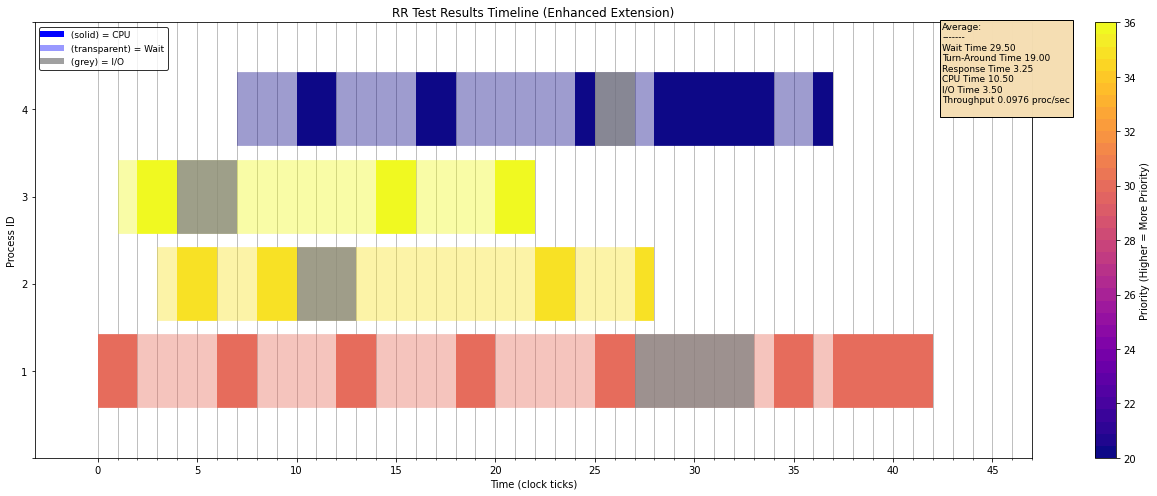

In [28]:
# Plotting both results enhanced (my own visualization)
operating_system.plotKernalResults(rr_results_all,
                       title="RR Test Results Timeline (Enhanced Extension)")


<br>

#### Fairness:
  As mentioned earlier RR can be unfair to I/O bound process because they
  might not use the full time of the quantum and then can be waiting for I/O
  as more and more processes arrive in the ready queue increasing the time
  for it to be worked on when it needs CPU work done again.

   This will be demonstrated below with a single I/O bound process and the
   rest CPU bound:

In [29]:
# making the unfair RR processes
unfair_rr_procs = [Process(1, [2, 35, 2], 1, 300),
                       Process(2, [5, 1, 6], 1, 24),
                       Process(3, [8, 3, 9], 5, 290),
                       Process(4, [7, 1, 6], 2, 423),
                       Process(5, [5, 3, 7], 4, 331),
                       Process(6, [9, 3, 9], 2, 389)]

# Run the kernel with RR and unfair processes with a quantum of 10
operating_system.kernal(scheduler.RR_scheduler, processes=unfair_rr_procs,
                            quantum=10, file_proc_name="unfair", debug=False)

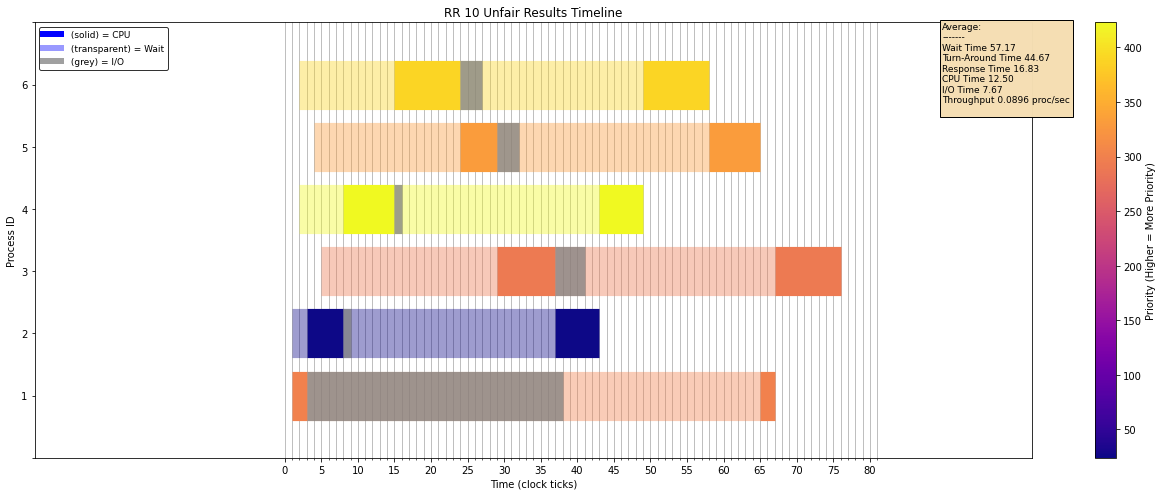

In [30]:
# Importing the CPU results from RR unfair
rr_unfair_results = pd.read_csv("data/Combined_Data/" +
                                    "All_RR_Q10_unfair_results.csv")

# plotting the results
operating_system.plotKernalResults(rr_unfair_results,
                                       title="RR 10 Unfair Results Timeline",
                                       figsize=(18, 7))

As we can see process 1 is I/O bound with an extremely long waiting time for
I/O input and short CPU bursts. This means that even though it arrives first
and is the first process to be run it does not use the entire time of the
quantum (in this simulation 10 clock ticks) before it is but into the waiting
 for I/O queue then as more and more processes that are CPU bound arrive the
 wait time between each process being run for a quantum increases by n*q time
 (where n is the number of processes in the ready queue and q is the length
 of a quantum in the RR algorithm). Also, as you can see from the graph above
 once a process is done waiting for I/O input it must wait for all other
 processes in the ready queue to have their quantum burst time before the
 process thant is done waiting for I/O input is ran. Here also the quantum is
  longer than any of the CPU burst times for any of the processes in the
  simulation so the RR algorithm is basically acting as a FCFS algorithm


Below I will show what happens when the quantum is much shorter at a length
of 2:

In [31]:
unfair_rr_procs = [Process(1, [2, 35, 2], 1, 300),
                       Process(2, [5, 1, 6], 1, 24),
                       Process(3, [8, 3, 9], 5, 290),
                       Process(4, [7, 1, 6], 2, 423),
                       Process(5, [5, 3, 7], 4, 331),
                       Process(6, [9, 3, 9], 2, 389)]
# Run the kernel with RR and unfair processes with a quantum of 20 and then 2
operating_system.kernal(scheduler.RR_scheduler, processes=unfair_rr_procs,
                            quantum=5, file_proc_name="unfair", debug=False)



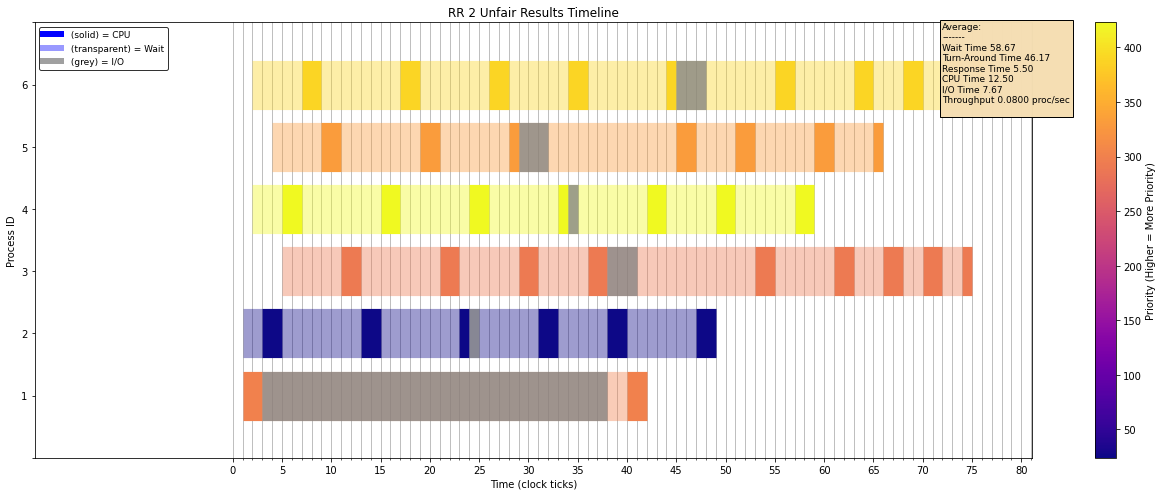

In [32]:
# Importing the CPU results from RR unfair
rr_unfair_results_2 = pd.read_csv("data/Combined_Data/" +
                                    "All_RR_Q2_unfair_results.csv")


# plotting the results
operating_system.plotKernalResults(rr_unfair_results_2,
                                       title="RR 2 Unfair Results Timeline",
                                       figsize=(18, 7))


When the quantum is much shorter with a length of 2 we can see there is a lot
 more context switching going on which in this case does decrease
 throughput with the throughput going from 0.0896 to 0.08 procs/sec. However,
 the advantage of a shorter quantum with much more context switching as seen
 above is that it can be much fairer to I/O bound processes because as
 mentioned earlier the waiting time for a process to be run after it has
 returned to the ready queue is n*q so since q, the length of the quantum
 haas decreased so does the wait time.

<br>

---
## Shortest Time Remaining (SRT):

 The Shortest Time Remaining algorithm associates each process with the
    length of its next CPU burst and then uses these lengths to so schedule
    the process with the shortest remaining time left, this is why it can
    also be though of as a preemptive SJF algorithm. The advantages of the
    SRT algorithm is that it is considered optimal meaning that it gives the
    minimum average wait time for a given set of processes. It also will give priority to I/O-bound jobs,
    which keeps the disks/network as busy as possible. However, because it
    gives priority to I/O bound processes that means SJF can be unfair to CPU
     bound processes. Another difficulty of implementing SRT is that the next
      CPU burst time for a process must be known for this algorithm.



   #### Testing:


Warning no processes were passed!! Making test Processes
Process ID: 1 , Start Time: 0 , End Time: 1
Process ID: 3 , Start Time: 1 , End Time: 3
Process ID: 2 , Start Time: 3 , End Time: 7
Process ID: 3 , Start Time: 7 , End Time: 11
Process ID: 2 , Start Time: 11 , End Time: 14
Process ID: 4 , Start Time: 14 , End Time: 19
Process ID: 1 , Start Time: 19 , End Time: 28
Process ID: 4 , Start Time: 28 , End Time: 35
Process ID: 1 , Start Time: 35 , End Time: 42


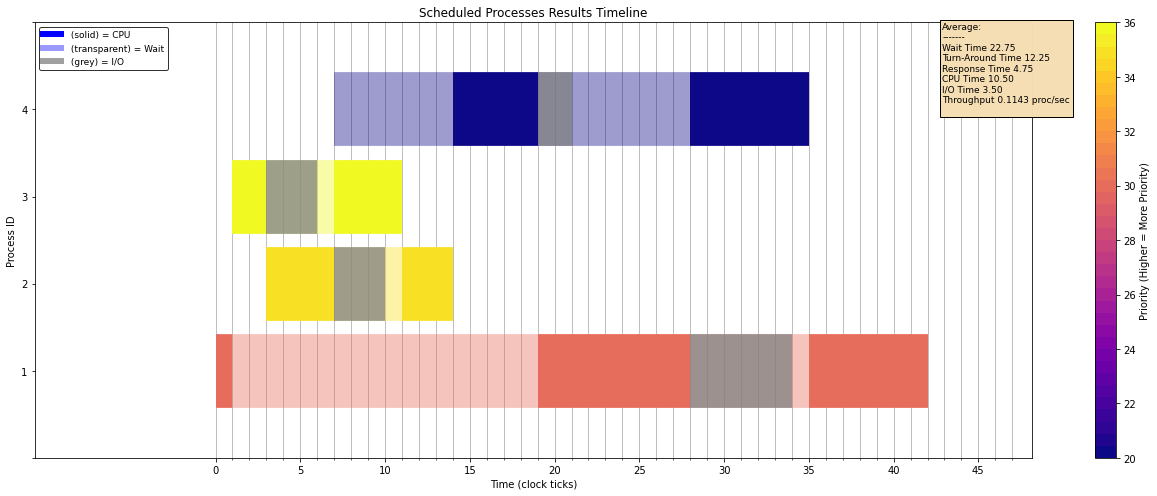

In [33]:
# Run the kernel with SRT and base test processes
operating_system.kernal(scheduler.SRT_scheduler,file_proc_name="test")

# Importing the results from SRT test
srt_results_all = pd.read_csv("data/Combined_Data/All_SRT_test_results.csv")

# Plotting the Results Enchanced
operating_system.plotKernalResults(srt_results_all,
                                   "SRT Test Results Timeline")


<br>

#### Fairness:
  As mentioned earlier SRT can be unfair to CPU bound process because by
  their definition they have much longer CPU burst times meaning that they
  will always be scheduled to run after shorter I/O bound processes. This can
   cause the CPU bound process to wait a very long time as more I/O bound
   processes arrive

   This will be demonstrated below with a single CPU bound process and the
   rest I/0 bound:

In [34]:
# making the unfair SRT processes
unfair_srt_procs = [Process(1, [6, 3, 5], 1, 300),
                       Process(2, [2, 5, 3], 3, 24),
                       Process(3, [1, 3, 1], 5, 290),
                       Process(4, [1, 4, 2], 8, 423),
                       Process(5, [3, 3, 1], 4, 331),
                       Process(6, [2, 3, 1], 2, 389)]

# Run the kernel with SRT and unfair processes
operating_system.kernal(scheduler.SRT_scheduler, processes=unfair_srt_procs,
                            file_proc_name="unfair", debug=False)

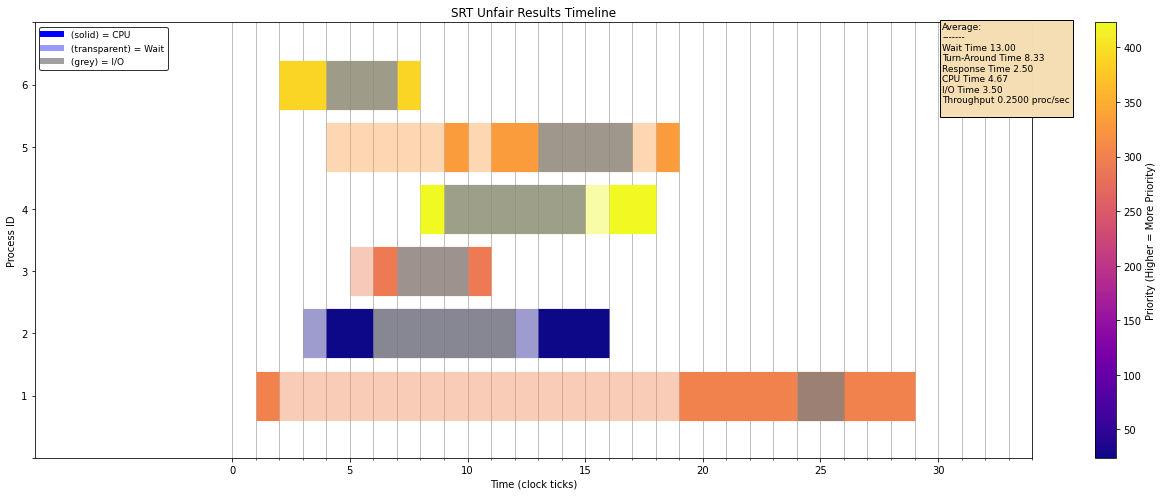

In [35]:
# Importing the CPU results from SRT unfair
srt_unfair_results = pd.read_csv("data/Combined_Data/" +
                                    "All_SRT_unfair_results.csv")

# plotting the results
operating_system.plotKernalResults(srt_unfair_results,
                                       title="SRT Unfair Results Timeline")

As we can see process 1 is CPU bound while the rest of the processes are I/O
bound. Even though process 1 is the first process to be scheduled and worked
on because it has such a long CPU burst time once all the I/O bound processes
 arrive process 1 is suspended until all the I/O bound processes have run,
 and then it continues to be run. This gives process 1 a much longer wait
 time than all the other I/O bound processes showing how SRT can be unfair to
  CPU bound processes.

<br>

---
## Preemptive Priority (PP):

The Preemptive Priority algorithm schedules jobs to be executed based on
their externally defined priority level. The Preemptive Priority algorithm
is basically a Priority scheduling algorithm expect it will not wait for a
lower priority process to finish running if another process with a higher
priority arrives to the ready queue. This means it can still face
problems like  being unfair with it being unfair to
processes with low priority (when it is an externally defined priority like for
this algorithm). This algorithm can also face starvation. One wau to prevent
this unfairness and starvation a bit is to age the processes in the ready
queue, where their priority increases the longer they stay in the ready queue.
One advantage of Preemptive Priority scheduling is that it can have very low
over head



   #### Testing:


Warning no processes were passed!! Making test Processes
Process ID: 1 , Start Time: 0 , End Time: 1
Process ID: 3 , Start Time: 1 , End Time: 3
Process ID: 2 , Start Time: 3 , End Time: 6
Process ID: 3 , Start Time: 6 , End Time: 10
Process ID: 2 , Start Time: 10 , End Time: 11
Process ID: 1 , Start Time: 11 , End Time: 14
Process ID: 2 , Start Time: 14 , End Time: 17
Process ID: 1 , Start Time: 17 , End Time: 23
Process ID: 4 , Start Time: 23 , End Time: 28
Process ID: 1 , Start Time: 28 , End Time: 35
Process ID: 4 , Start Time: 35 , End Time: 42


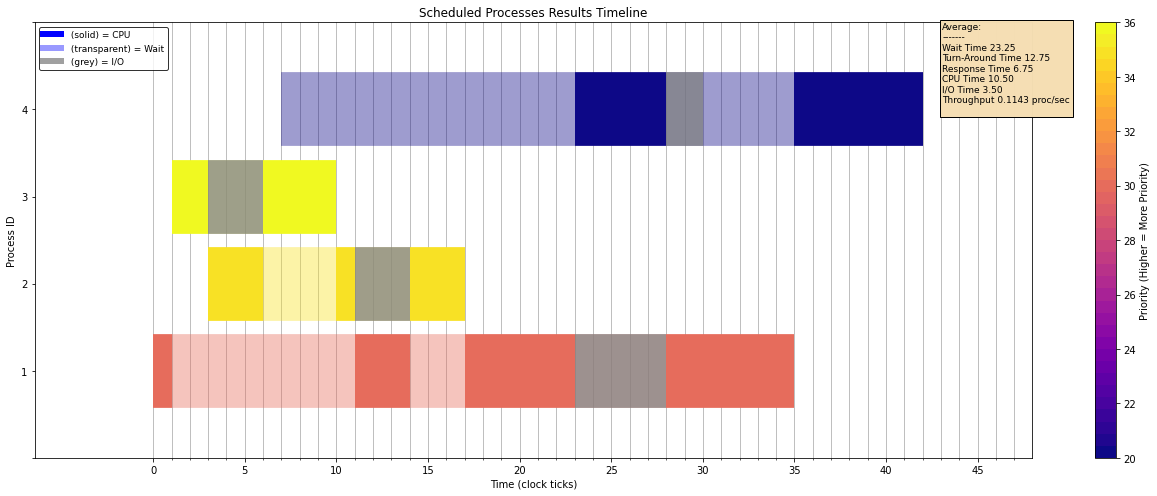

In [36]:
# Run the kernel with RR and base test processes
operating_system.kernal(scheduler.Preemptive_Priority_scheduler
                        ,file_proc_name="test")


# Importing the results from RR test
pp_results_all = pd.read_csv\
    ("data/Combined_Data/All_Preemptive_Priority_test_results.csv")

# Plotting the Results Enchanced
operating_system.plotKernalResults(pp_results_all,
                                   "PP Test Results Timeline")

<br>

#### Fairness:

As mentioned earlier preemptive priority scheduling can be very unfair to
processes with low priority (Especially in this case where the priorities for
 each process are assigned externally). This can lead to processes with low
 priority levels having very long wait times and even at times starvation
 could occur.

   This will be demonstrated below:

In [37]:
# making the unfair PP processes
unfair_pp_procs = [Process(1, [4, 3, 4], 1, 34),
                       Process(2, [2, 5, 3], 3, 424),
                       Process(3, [5, 3, 4], 5, 290),
                       Process(4, [6, 4, 3], 8, 123),
                       Process(5, [3, 3, 6], 4, 531),
                       Process(6, [5, 3, 2], 2, 389)]

# Run the kernel with PP and unfair processes
operating_system.kernal(scheduler.Preemptive_Priority_scheduler, processes=unfair_pp_procs,
                            file_proc_name="unfair", debug=False)

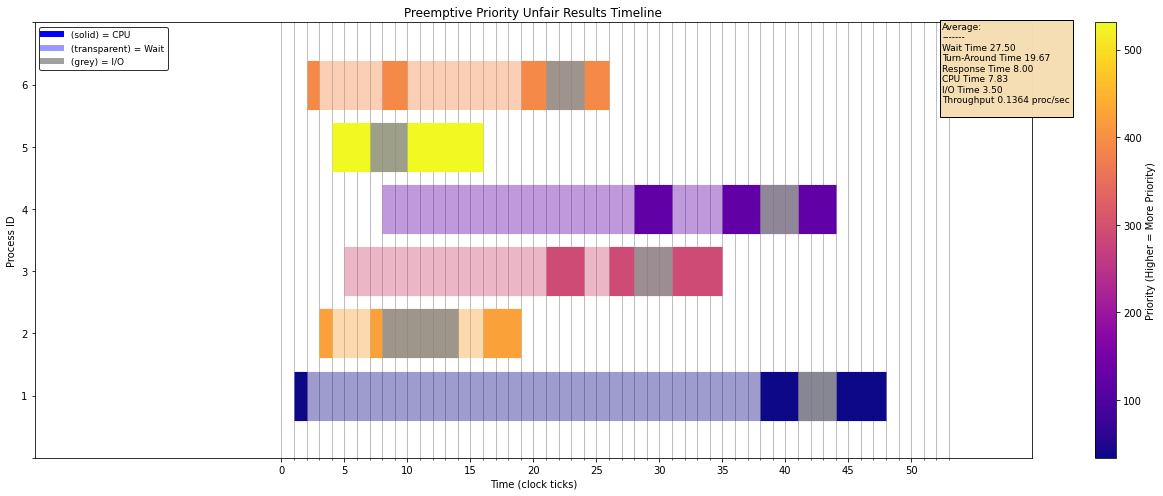

In [38]:
# Importing the CPU results from PP unfair
pp_unfair_results = pd.read_csv("data/Combined_Data/" +
                                    "All_Preemptive_Priority_unfair_results.csv")

# plotting the results
operating_system.plotKernalResults(pp_unfair_results,
                                       title="Preemptive Priority Unfair "
                                             "Results Timeline")


As we can see even though process 1 is scheduled and worked on first it then
has to wait a very long time until all the other processes with priorities
higher than it have finished running (or are waiting for I/O input such as
with process 4) unit it can continue running. This cause low priority
processes, such as process 1, to have such long wait times making preemptive
priority scheduling unfair to them.

<br>

---
## Multilevel Feedback Queue (MLFQ) (Extension):

   The Multilevel Feedback Queue algorithm is defined by its number of
    queues, the scheduling algorithm for each queue (can be preemptive or
    not), methods used to upgrade and demote a process and methods to choose
    which queue a process will enter, and priorities are given for each queue
    .  For my implementation of a MLFQ it consists of 3 queses with the first
    2 highest priorities use the round-robin scheduling algorithm with
    quantum defined by the user (usually best to make the first, the highest
    priority RR queue quantum shorter than the second RR queue's quantum) and
     then the finial and lowest priority queue uses a non-preemptive first
     come first served algorithm meaning that any process that arrives in this
      queue will run until it is complete. A process is transferred from one
      queue to another lower priority queue if the process' current CPU burst
       time is not complete within the quantum of that RR queue, once it is
       in the FCFS queue it stays there. (In the graphs below the priority
       level / color is associated with the queue tha the process is in)



   #### Testing with a 2q, 7q, FCFS MLFQ:
   (Here I used a 2,7 MLFQ so it processes get to all queues)


Warning no processes were passed!! Making test Processes
Process ID: 1 , Start Time: 0 , End Time: 2
Process ID: 3 , Start Time: 2 , End Time: 4
Process ID: 2 , Start Time: 4 , End Time: 6
Process ID: 1 , Start Time: 6 , End Time: 13
Process ID: 4 , Start Time: 13 , End Time: 15
Process ID: 3 , Start Time: 15 , End Time: 17
Process ID: 2 , Start Time: 17 , End Time: 19
Process ID: 4 , Start Time: 19 , End Time: 22
Process ID: 3 , Start Time: 22 , End Time: 24
Process ID: 2 , Start Time: 24 , End Time: 27
Process ID: 4 , Start Time: 27 , End Time: 34
Process ID: 1 , Start Time: 34 , End Time: 35
Process ID: 1 , Start Time: 35 , End Time: 42


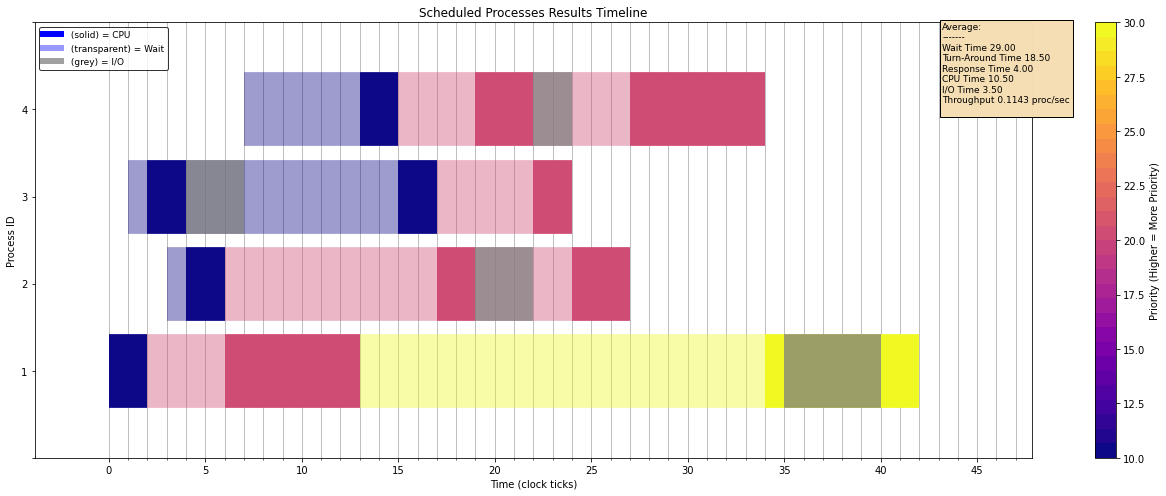

In [39]:
# Run the kernel with RR and base test processes
operating_system.kernal(scheduler.MLFQ_scheduler,file_proc_name="test")

# Importing the results from RR test
mlfq_results_all = pd.read_csv("data/Combined_Data/All_MLFQ_test_results.csv")

# Plotting the Results Enhanced
operating_system.plotKernalResults(mlfq_results_all,
                                   "MLFQ Test Results Timeline")


<br>

---
## Preemptive Response (Extension):

The Preemptive Response algorithm is a scheduling algorithm
        I came up with that is designed to maximize response time for an
        algorithm. It is basically a round robin / FCFS mix algorithm,
        however a process that is running is preempted if another processes arrives in the ready
        queue that has not been ran yet


   #### Testing:

Warning no processes were passed!! Making test Processes
Process ID: 1 , Start Time: 0 , End Time: 1
Process ID: 3 , Start Time: 1 , End Time: 2
Process ID: 1 , Start Time: 2 , End Time: 3
Process ID: 2 , Start Time: 3 , End Time: 4
Process ID: 3 , Start Time: 4 , End Time: 5
Process ID: 2 , Start Time: 5 , End Time: 6
Process ID: 1 , Start Time: 6 , End Time: 7
Process ID: 4 , Start Time: 7 , End Time: 8
Process ID: 4 , Start Time: 8 , End Time: 9
Process ID: 3 , Start Time: 9 , End Time: 13
Process ID: 2 , Start Time: 13 , End Time: 15
Process ID: 4 , Start Time: 15 , End Time: 16
Process ID: 1 , Start Time: 16 , End Time: 23
Process ID: 2 , Start Time: 23 , End Time: 26
Process ID: 4 , Start Time: 26 , End Time: 28
Process ID: 1 , Start Time: 28 , End Time: 35
Process ID: 4 , Start Time: 35 , End Time: 42


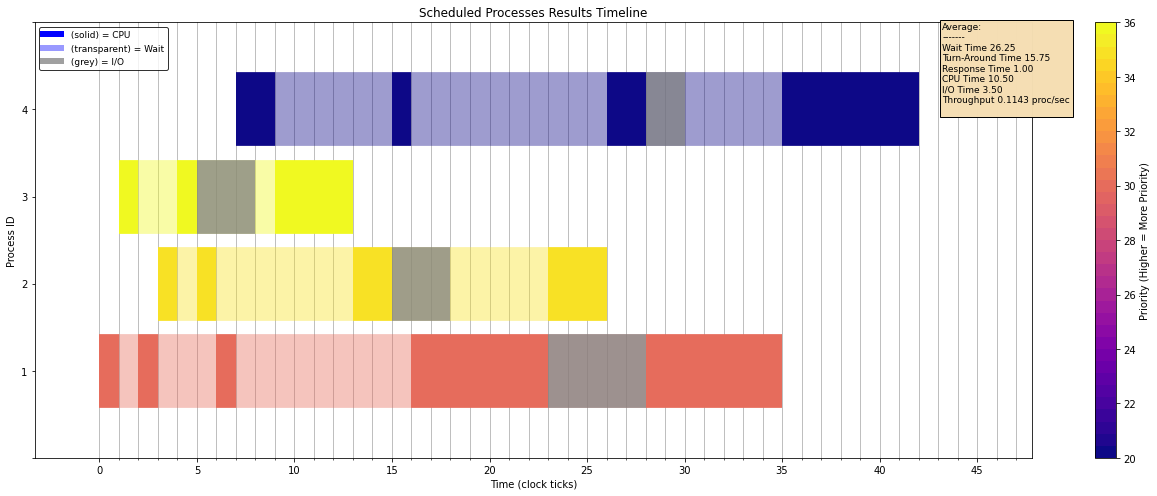

In [40]:
# Run the kernel with RR and base test processes
operating_system.kernal(scheduler.Preemptive_Response_scheduler,
                        file_proc_name="test")
# Importing the results from RR test
pr_results_all = pd.read_csv("data/Combined_Data/All_Preemptive_Response_test_results.csv")

# Plotting the Results Enhanced
operating_system.plotKernalResults(pr_results_all,
                                   "Preemptive Response Test Results Timeline")


From plotting the results we can see that this algorithm is basically FCFS
except when there is a new processes in the ready queue the current process
temporarily stops working while the new process is run for a clock tick until
 the other process that was originally running is run again.

<br>

---
## Simulations:

Now I will run simulations with a 50/50 split of CPU and I/O bound processes
to compare the general statistics such as the average turnaround time,
response time, wait time, and throughput of the following 4 scheduling
algorithms:

    - Round Robin with quantum of 2
    - Round Robin with quantum of 10
    - Shortest Remaining Time
    - Multilevel Feedback Queue (RR2 => RR 10 => FCFS)
    - Preemptive Response (My Extension)


Below I will run these simulations:

##### Setting up Process:

In [41]:
sim_procs1 = operating_system.generate_processes(n =1000,seed=1)
sim_procs2 = copy.deepcopy(sim_procs1)
sim_procs3 = copy.deepcopy(sim_procs1)
sim_procs4 = copy.deepcopy(sim_procs1)
sim_procs5 = copy.deepcopy(sim_procs1)

#### Round Robin with quantum of 2:

In [42]:
# Run the kernel with RR2 and processes
operating_system.kernal(scheduler.RR_scheduler,quantum=2, processes=sim_procs1,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from RR2
rr_q2_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_RR_Q2_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(rr_q2_sim_results, title = "Round Robin Q2 Sim")

Average Round Robin Q2 Sim Stats:
-------
Wait Time 1264.19
Turn-Around Time 1252.33
Response Time 97.09
CPU Time 11.87
I/O Time 6.06
Throughput 0.0843 proc/sec



#### Round Robin with quantum of 10:

In [43]:
# Run the kernel with RR10 and processes
operating_system.kernal(scheduler.RR_scheduler,quantum=10, processes=sim_procs2,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from RR10
rr_q10_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_RR_Q10_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(rr_q10_sim_results, title = "Round Robin Q10 Sim")



Average Round Robin Q10 Sim Stats:
-------
Wait Time 1538.09
Turn-Around Time 1526.22
Response Time 341.96
CPU Time 11.87
I/O Time 6.06
Throughput 0.0843 proc/sec



#### Shortest Remaining Time:

In [44]:
# Run the kernel with SRT and processes
operating_system.kernal(scheduler.SRT_scheduler, processes=sim_procs3,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from SRT
srt_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_SRT_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(srt_sim_results, title = "SRT Sim")


Average SRT Sim Stats:
-------
Wait Time 677.89
Turn-Around Time 666.03
Response Time 323.89
CPU Time 11.87
I/O Time 6.06
Throughput 0.0843 proc/sec



#### Multilevel Feedback Queue (RR2 => RR 10 => FCFS):

In [45]:
# Run the kernel with MLFQ and processes
operating_system.kernal(scheduler.MLFQ_scheduler, processes=sim_procs4,
                        quantum= 2, quantum2= 10,
                            file_proc_name="2_10_sim", debug=False)

# Importing the CPU results from MLFQ
mlfq_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_MLFQ_2_10_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(mlfq_sim_results, title = "MLFQ_2_10 Sim")

Average MLFQ_2_10 Sim Stats:
-------
Wait Time 2204.58
Turn-Around Time 2192.72
Response Time 3.13
CPU Time 11.87
I/O Time 6.06
Throughput 0.0843 proc/sec



#### Preemptive Response (My Extension):

In [46]:
# Run the kernel with PR and processes
operating_system.kernal(scheduler.Preemptive_Response_scheduler, processes=sim_procs5,
                            file_proc_name="sim", debug=False)

# Importing the CPU results from PR
pr_sim_results = pd.read_csv("data/Combined_Data/" +
                                    "All_Preemptive_Response_sim_results.csv")

# printing the results
operating_system.printKernalResultStats(pr_sim_results, title = "Preemptive"
                                                                  " Response Sim")


Average Preemptive Response Sim Stats:
-------
Wait Time 1282.84
Turn-Around Time 1270.98
Response Time -0.92
CPU Time 11.87
I/O Time 6.06
Throughput 0.0843 proc/sec



#### Simulation observations:

From running the four different scheduling algorithms with the same processes
 I can make a few observations from the results. To start off with it is
 interesting that throughput is basically the same for all 4 scheduling
 algorithms with the throughput being the same for all 4 of them. I am
 thinking this is either dues to it being a single cpu working on all the
 processes, and it never faces starvation/idle time during scheduling any of
 these processes so the CPU is always working on a process thus they all are
 done completing at the same time. (This goes against what I would have
 thought but also it kind of makes sense because the first 3 scheduling
 algorithms are basically the 3 queue algorithms for the MLFQ, expect the
 final queue is FCFS and not SJF). The next observation I made was that the
 round-robin algorithm with a quantum of 2 had a much shorter response time
 than the round-robin algorithm with a quantum of 10, which makes sense
 because the RR with a quantum of 2 is context switching much more often so it
  has a shorter time to work on a process that ahs just arrived to the ready
  queue (in fact is has a higher response time then the SRT algorithm as
  well). I also notice when comparing RR 2 with RR 10, round-robin with a
  quantum of 2 also has less of an average wait time and turnaround time
  which also make sense when it is considered that a majority of the
  processes have a current CPU burst time of 10 or less, because I/O bound
  processes range from 1-3 CPU burst times by default and CPU bound process
  range from 8-12 CPU burst time by default. This means that a RR algorithm
  with a quantum of 10 is basically acting as a FCFS algorithm for a majority
  of the processes.

Also, from the simulations it is confirmed that overall the Shortest Remaining
Time scheduling algorithm is in fact the most optimal algorithm in the sense
 that it results in the minimum average waiting time for any given set of
 processes.

Finally, when looking at the results for the Multilevel Feedback Queue (RR2
=> RR 10 => FCFS) I see that it preforms the worst in sense of average turn
around and wait time however it has by far the best average response time out
 of the algorithms. The best average response time makes sense because the
 queue with the highest priority is the RR 2 queue which as I mentioned
 earlier has a very fast response time when compared to RR10 and SRT. This
 means that it always has priority to run and if a process CPU burst is not
 finished in a quantum of 2  it is moved to the next lower priority queue
 meaning that there is also not as many processes in the RR2 queue resulting
 in it being able to respond to new processes quicker because as I have been
 mentioning wait time for a process in a round-robin queue is calculated by
 n*q. It also makes sense why it would have a longer average wait times and
 turn around times because as more and more processes are being pushed to the
  lower priority queses they have to wait for all the processes in the higher
   priority queses to be run compounding on their wait time and thus
   turnaround time.


##### Extension Sim analysis:
  When looking at my custom Preemptive response time algorithm I have indeed
   created a preemptive algorithm with an extremely short average response time.
    It also has an average wait time and turnaround time similar to that of
    RR with a quantum of 2 which makes me very pleased with the algorithim I
    came up with.




<br>

---

## References and Acnowlagements

On this project I received help and knowledge from :
   - [Prof. Al Madi](https://www.cs.colby.edu/nsalmadi/)
   - [Matplotlib event plot documentation](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.eventplot.html)
   - [General Matplotlib Docs](https://matplotlib.org/)
   - [Project Details](https://github.com/mattjax16/CS337-Operating-Systems/blob/master/Projects/Proj2/Project%202_%20Preemptive%20CPU%20Scheduling.pdf)
   - [Stanford Scheduling Powerpoint](https://www.scs.stanford.edu/07au-cs140/notes/l5.pdf)
   -[Stanford Scheduling Notes](https://web.stanford.edu/~ouster/cgi-bin/cs140-spring14/lecture.php?topic=scheduling)

   - [Guru 99](https://www.guru99.com/cpu-scheduling-algorithms.html)



